# OSDG Classifier using scikit-learn

[OSDG Community Dataset](https://zenodo.org/record/5550238#.YYL53i8RrRY).
***

## Table of Contents

- [I. Data Preparation](#I.-Data-Preparation)

- [II. SVM Classifier for Sustainable Development Goals]

![17 SDGs](https://global.unitednations.entermediadb.net/assets/mediadb/services/module/asset/downloads/preset/assets/2015/09/22525/image1170x530cropped.jpg)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing  Libraries

In [16]:
# standard library
from typing import List

# data wrangling
import numpy as np
import pandas as pd

# visualisation
import plotly.express as px
import plotly.io as pio

# nlp
import spacy

#deployment application


# data modelling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, top_k_accuracy_score, f1_score

# utils
from tqdm import tqdm
from sklearn import svm

# local packages
from helpers import plot_confusion_matrix, fix_sdg_name

print('Loaded!')

Loaded!


In [3]:
# other settings
pio.templates.default = 'plotly_white'

spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm', disable = ['ner'])
print('SpaCy version:', spacy.__version__)

SpaCy version: 2.2.4


# I. Data Preparation

_In this section, we will explore the data and select texts for training._

## Loading Dataset

In [4]:
df_osdg = pd.read_csv('https://zenodo.org/record/5550238/files/osdg-community-dataset-v21-09-30.csv?download=1')
print('Shape:', df_osdg.shape)
display(df_osdg.head())

Shape: (32121, 7)


,doi,text_id,text,sdg,labels_negative,labels_positive,agreement
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,7,0.750000
1,10.18356/eca72908-en,00028349a7f9b2485ff344ae44ccfd6b,Labour legislation regulates maximum working h...,11,2,1,0.333333
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,6,0.714286
3,10.1787/5k9b7bn5qzvd-en,0006a887475ccfa5a7f5f51d4ac83d02,The extent to which they are akin to corruptio...,3,1,2,0.333333
4,10.1787/9789264258211-6-en,0006d6e7593776abbdf4a6f985ea6d95,A region reporting a higher rate will not earn...,3,2,2,0.000000


The agreement is calculated using the following formula:

$$
agreement = \frac{|labels_{pos} - labels_{neg}|}{labels_{pos} + labels_{neg}}
$$

The resulting values range between 0 (equally split votes) and 1 (all votes are either positive or negative).

## Cummative probability of Agreement scores

In [5]:
# calculating cumulative probability over agreement scores
df_lambda = df_osdg['agreement'].value_counts(normalize = True).sort_index().cumsum().to_frame(name = 'p_sum')
df_lambda.reset_index(inplace = True)
df_lambda.rename({'index': 'agreement'}, axis = 1, inplace = True)

print('Shape:', df_lambda.shape)
display(df_lambda.head())

Shape: (36, 2)


,agreement,p_sum
0,0.000000,0.033716
1,0.062432,0.033747
2,0.067982,0.033779
3,0.090909,0.033872
4,0.111111,0.050185


#Filter Dataset Based on Agreement scores
##The orginal dataset is filtered by agreement scores.A threshold of 0.6 or more is considered.

In [6]:
# keeping only the texts whose suggested sdg labels is accepted and the agreement score is at least .6
print('Shape before:', df_osdg.shape)
df_osdg = df_osdg.query('agreement >= .6 and labels_positive > labels_negative').copy()
print('Shape after :', df_osdg.shape)
display(df_osdg.head())

Shape before: (32121, 7)
Shape after : (17233, 7)


,doi,text_id,text,sdg,labels_negative,labels_positive,agreement
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,7,0.750000
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,6,0.714286
7,10.1787/9789264117563-8-en,000bfb17e9f3a00d4515ab59c5c487e7,The Israel Oceanographic and Limnological Rese...,6,0,3,1.000000
8,10.18356/805b1ae4-en,001180f5dd9a821e651ed51e30d0cf8c,Previous chapters have discussed ways to make ...,2,0,3,1.000000
11,10.1787/9789264310278-en,001f1aee4013cb098da17a979c38bc57,Prescription rates appear to be higher where l...,8,0,3,1.000000


##Count for each SDG category

In [7]:
df_lambda = df_osdg.groupby('sdg', as_index = False).agg(count = ('text_id', 'count'))
df_lambda['share'] = df_lambda['count'].divide(df_lambda['count'].sum()).multiply(100)
print('Shape:', df_lambda.shape)
display(df_lambda)

Shape: (15, 3)


,sdg,count,share
0,1,1146,6.650032
1,2,827,4.798932
2,3,1854,10.758429
3,4,2324,13.485754
4,5,2286,13.265247
5,6,1343,7.793187
6,7,1589,9.220681
7,8,859,4.984623
8,9,688,3.992340
9,10,437,2.535832


In [8]:
fig = px.bar(
    data_frame = df_lambda,
    x = 'sdg',
    y = 'count',
    custom_data = ['share'],
    labels = {
        'sdg': 'SDG',
        'count': 'Count'
    },
    color_discrete_sequence = ['#1f77b4'],
    title = 'Figure 2. Distribution of Texts (Agreement >.6) over SDGs'
)

fig.update_traces(hovertemplate = 'SDG %{x}<br>Count: %{y}<br>Share: %{customdata:.2f}%')
fig.update_layout(xaxis = {'type': 'category'})
fig.show()

## III.SVM Classifier for Sustainable Development Goals

_In this section, we extend the model to a multiclass case by training a Support Vector Machines capable of classifying text input in one of 15 different SDGs._

**Highlights:**

- More sophisticated preprocessing using `spaCy`.
- Instances are represented as a real-valued vectors from a `TfIdf` matrix.
- A SVM classifier is trained on 15 SDGs.
- Test accuracy and (weighted) F1 scores both stand at `.86`.


##Preprocessing

###This involves tokenization of text,POS-tagging,lemmation..Common stop words are removed from text for better processing

In [9]:
def preprocess_spacy(alpha: List[str]) -> List[str]:
    """
    Preprocess text input using spaCy.
    
    Parameters
    ----------
    alpha: List[str]
        a text corpus.
    
    Returns
    -------
    doc: List[str]
        a cleaned version of the original text corpus.
    """
    docs = list()
    
    for doc in tqdm(nlp.pipe(alpha, batch_size = 128)):
        tokens = list()
        for token in doc:
            if token.pos_ in ['NOUN', 'VERB', 'ADJ']:
                tokens.append(token.lemma_)
        docs.append(' '.join(tokens))
        
    return docs

In [10]:
df_osdg['docs'] = preprocess_spacy(df_osdg['text'].values)
print('Shape:', df_osdg.shape)
display(df_osdg.head())

17233it [01:05, 262.72it/s]

Shape: (17233, 8)


,doi,text_id,text,sdg,labels_negative,labels_positive,agreement,docs
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,7,0.750000,gender perspective point labour market fishing...
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,6,0.714286,average figure mask large difference region nu...
7,10.1787/9789264117563-8-en,000bfb17e9f3a00d4515ab59c5c487e7,The Israel Oceanographic and Limnological Rese...,6,0,3,1.000000,station monitor quantity quality water coastli...
8,10.18356/805b1ae4-en,001180f5dd9a821e651ed51e30d0cf8c,Previous chapters have discussed ways to make ...,2,0,3,1.000000,previous chapter discuss way make food system ...
11,10.1787/9789264310278-en,001f1aee4013cb098da17a979c38bc57,Prescription rates appear to be higher where l...,8,0,3,1.000000,prescription rate appear high labour force par...


##Spliting into Train and Test set

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df_osdg['docs'].values, 
    df_osdg['sdg'].values, 
    test_size = .3,
    random_state = 42
)

print('Shape train:', X_train.shape)
print('Shape test:', X_test.shape)

Shape train: (12063,)
Shape test: (5170,)


#Grid search optimization

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

clf=GridSearchCV(svm.SVC(gamma='auto'),{
    'C':[1,3,10,20],'kernel':['rbf','linear']
    },cv=5, return_train_score=False)

clf.fit(X_Train,y_train)
df=pd.DataFrame(clf.cv_results_)
df

##Performing SVM Classification and Obtainig accuracy

### Model performs with aproximatly 87 percent accuracy.

In [13]:

text_clf_svm = Pipeline([('tfidf', TfidfVectorizer()),
                      ('clf-svm', svm.SVC(C=1.0,kernel='linear',degree=3,gamma='auto',probability=True)),
 ]) 
text_clf_svm.fit(X_train, y_train)
predicted_svm = text_clf_svm.predict(X_test)
np.mean(predicted_svm == y_test)

0.8690522243713733

##Confusion Matrix

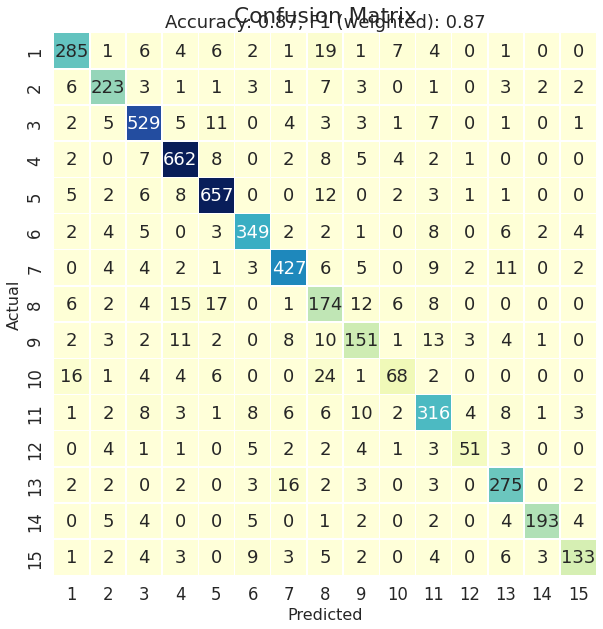

In [20]:
from sklearn.metrics import  confusion_matrix
y_hat = text_clf_svm.predict(X_test)
plot_confusion_matrix(y_test, y_hat)

##Precision and Recall

In [22]:
from sklearn.metrics import  recall_score,precision_score


recall=recall_score(y_test,y_hat,average='micro')
precision=precision_score(y_test,y_hat,average='micro')
print("Recall score :",recall,"\nPrecision score",precision)

Recall score : 0.8690522243713733 
Precision score 0.8690522243713733


##Classification Summary

In [21]:
print(classification_report(y_test, y_hat, zero_division = 0))

              precision    recall  f1-score   support

           1       0.86      0.85      0.85       337
           2       0.86      0.87      0.86       256
           3       0.90      0.92      0.91       572
           4       0.92      0.94      0.93       701
           5       0.92      0.94      0.93       697
           6       0.90      0.90      0.90       388
           7       0.90      0.90      0.90       476
           8       0.62      0.71      0.66       245
           9       0.74      0.72      0.73       211
          10       0.74      0.54      0.62       126
          11       0.82      0.83      0.83       379
          12       0.82      0.66      0.73        77
          13       0.85      0.89      0.87       310
          14       0.96      0.88      0.91       220
          15       0.88      0.76      0.82       175

    accuracy                           0.87      5170
   macro avg       0.85      0.82      0.83      5170
weighted avg       0.87   

In [ ]:
import pickle

path='/content/drive/MyDrive/Pickle Folder/'
pickle_out=open(path+"Clf.pickle","wb")
pickle.dump(text_clf_svm,pickle_out)
pickle_out.close()